In [51]:
import subprocess
from PIL import Image
import os, sys
import numpy as np
import pandas as pd
from math import sqrt, exp, pi
from matplotlib import pyplot as plt

# Resize datasets size to 100x100

In [2]:
'''Cây thư mục cho dataset
dataset
    training_set
        cats
            cat.1.jpg
            cat.2.jpg
            ...
        dogs
    test_set
        cats
        dogs
'''
datasets = ['training_set/', 'test_set/']
datasets_type = ['cats/', 'dogs/']
list_path_output = ['training_cat', 'training_dog', 'test_cat', 'test_dog']
#os.listdir('dataset/'+datasets[0]+datasets_type[1])

In [3]:
def resize_image_dirs(path):
    dirs = os.listdir(path)
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((100,100), Image.ANTIALIAS)
            imResize.save(f+'.jpg', 'JPEG', quality=90)

def export_list_paths(path, output_name):
    dirs = os.listdir(path)
    filehandle = open(output_name, 'w')
    for item in dirs:
        if os.path.isfile(path+item):
            filehandle.write(path+item+'\n')
    filehandle.close()

In [4]:
#resize_image_dirs('dataset/test_set/dogs/')

# Vòng lặp này sẽ resize bộ ảnh về 100x100, jpg
# for dataset in datasets:
#     for datatype in datasets_type:
#         path = 'dataset/'+dataset+datatype
#         resize_image_dirs(path)

## Trích xuất đặc trưng theo chuẩn MPEG7 sử dụng công cụ MPEG7Fex
- Link download: www.cs.bilkent.edu.tr/~bilmdg/bilvideo-7/Software.html
- Loại đặc trưng: Dominant Color

### Tạo danh sách chứa tên đường dẫn các hình

In [5]:
list_path = []
for dataset in datasets:
    for datatype in datasets_type:
        path = 'dataset/'+dataset+datatype
        list_path.append(path)

for index in range(len(list_path)):
    export_list_paths(list_path[index], list_path_output[index]+'.txt')

print(list_path)

['dataset/training_set/cats/', 'dataset/training_set/dogs/', 'dataset/test_set/cats/', 'dataset/test_set/dogs/']


### Trích xuất đặc trưng DCD bằng MPEG7Fex
Chỉ cần chạy 1 lần là đủ

In [6]:
sf_path = 'MPEG7Fex.exe'
descriptor = 'DCD'
normalize_flag = '1'
variance_flag = '0'
spatial_flag = '1'

In [59]:
def feature_extract_np(path, fex_output='testDCD.txt'):
    #resize image to intended size
    if os.path.isfile(path):
        im = Image.open(path)
        im = im.convert('RGB')
        imResize = im.resize((100,100), Image.ANTIALIAS)
        imResize.save('input.jpg', 'JPEG', quality=90)
    
    #make input_image.txt
    f = open('input_image.txt','w')
    f.write('input.jpg')
    f.close()
    
    subprocess.call([sf_path,descriptor, normalize_flag, variance_flag, spatial_flag,'input_image.txt',fex_output])
    
    f = open(fex_output)
    content = f.readlines()
    f.close()
    
    content = [x.strip() for x in content] 
    content = [x[x.find(' ')+1:].replace(' ', ',') for x in content]
    for index in range(len(content)):
        tmp = [0]*34
        tmp[0:len(content[index].split(','))] = [int(x) for x in content[index].split(',')]
        content[index] = tmp
    
    del f
    return np.array(content)[0]

In [37]:
for index in range(len(list_path_output)):
    input_file_list = list_path_output[index]+'.txt'
    output_file_list = list_path_output[index]+'DCD.txt'
    subprocess.call([sf_path,descriptor, normalize_flag, variance_flag, spatial_flag,input_file_list,output_file_list])

### Xuất thông số theo csv

In [38]:
def build_dataframe(path, output):
    #read data from txt
    with open(path) as f:
        content = f.readlines()
    f.close()
    content = [x.strip() for x in content] 
    content = [x[x.find(' ')+1:].replace(' ', ',') for x in content]
    for index in range(len(content)):
        tmp = [0]*34
        tmp[0:len(content[index].split(','))] = [int(x) for x in content[index].split(',')]
        content[index] = tmp
    
    #write as csv
    f = open(output,'w')
    ## write headlines
        # numberOfDominantColors spatialCoherency
        # percentage_1
        # centroid_1_channel1 centroid_1_channel2 centroid_1_channel3
        # variance_1_channel1 variance_1_channel2 variance_1_channel3
    
    f.write('numberOfDominantColors,spatialCoherency,')
    for index in range(8):
        f.write('percent_{},centroid_{}_r,centroid_{}_g,centroid_{}_b,'.format(index,index,index,index))
        #f.write('var_{}_r,var_{}_g,var_{}_b,'.format(index,index,index))
    f.seek(f.tell() - 1, os.SEEK_SET)
    f.truncate()
    f.write('\n')
    
    ## write values
    for line in content:
        for value in line:
            f.write(str(value) + ',')
        f.seek(f.tell() - 1, os.SEEK_SET)
        f.truncate()
        f.write('\n')

    f.close()
    del f

In [39]:
build_dataframe('training_catDCD.txt', 'dataframe_training_cat.csv')
build_dataframe('training_dogDCD.txt', 'dataframe_training_dog.csv')
build_dataframe('test_catDCD.txt', 'dataframe_test_cat.csv')
build_dataframe('test_dogDCD.txt', 'dataframe_test_dog.csv')

### Xử dụng pandas để load dữ liệu và tính toán

In [40]:
def gaussian_pdf(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

def predict(test_y, cat_classifier, dog_classifier):
    p_cat = cat_classifier[2]
    p_dog = dog_classifier[2]
    for index in range(len(test_y)):
        p_cat *= gaussian_pdf(test_y[index],cat_classifier[0][index],cat_classifier[1][index])
        p_dog *= gaussian_pdf(test_y[index],dog_classifier[0][index],dog_classifier[1][index])
    
    if p_cat > p_dog:
        return 0
    return 1

In [41]:
label_y = ['cat', 'dog']
samples = []
df = pd.read_csv('dataframe_training_cat.csv')
mean = df.mean().values
stdev = df.std().values
samples.append(df.shape[0])
cat_classifier = [mean, stdev]

In [42]:
df = pd.read_csv('dataframe_training_dog.csv')
mean = df.mean().values
stdev = df.std().values
samples.append(df.shape[0])
dog_classifier = [mean, stdev]

In [43]:
cat_classifier.append(samples[0]/(samples[0]+samples[1]))
dog_classifier.append(samples[1]/(samples[0]+samples[1]))

### Đánh giá mô hình

In [44]:
#test_cat
df = pd.read_csv('dataframe_test_cat.csv')
result = []
correct_prediction = 0
for test in df.values:
    result.append(predict(test,cat_classifier,dog_classifier))
result = np.array(result)
correct_prediction = len(result) - np.count_nonzero(result)
print(correct_prediction/len(result))

0.745


In [45]:
#test_dog
df = pd.read_csv('dataframe_test_dog.csv')
result = []
for test in df.values:
    result.append(predict(test,cat_classifier,dog_classifier))
result = np.array(result)
correct_prediction += np.count_nonzero(result)


In [46]:
print(correct_prediction)
print(correct_prediction/2000)

1098
0.549


### Thử nghiệm

[ 7  9  2  4  4  3  3 11  7  5  5 30 30 30  2 17  9  3  6  8 10  9  8 19
 15 12  2 18 19 19  0  0  0  0]


'dog'

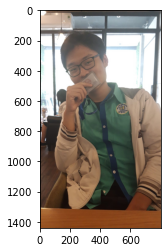

In [61]:
src = 'khoi.png'
test_y = feature_extract_np(src)
print(test_y)
plt.imshow(plt.imread(src))
label_y[predict(test_y,cat_classifier, dog_classifier)]